In [1]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
%matplotlib nbagg

In [2]:
#Model parameters
width = 250
bounce_loss = 0.9
g = -0.981
friction = 0.999


class Point:
    """A point class, containing a single point on a rope"""
    
    
    def __init__(self, x, y, prev_x, prev_y, fixed=False, draggable=False):
        #Current position
        self.x = x
        self.y = y
        
        #Previous position (for Verlet Integration)
        self.prev_x = prev_x
        self.prev_y = prev_y
        
        #Allowing for a fixed point:
        self.fixed = fixed
        self.draggable = draggable
        
    def update(self):
        if self.fixed:
            return True
        
        #Find velocity from current position and last position
        vx = (self.x - self.prev_x) * friction
        vy = (self.y - self.prev_y) * friction
        
        #Update old positions
        self.prev_x, self.prev_y = self.x, self.y
        
        #Update new positions
        self.x += vx
        self.y += vy + g * dt
        
        #Check if the point has gone out of bounds
        if self.x > width:
            self.x = width
            self.prev_x = self.x + vx * bounce_loss
            
        if self.y > width:
            self.y = width
            self.prev_y = self.y + vy * bounce_loss
            
        if self.x < 0:
            self.x = 0
            self.prev_x = vx * bounce_loss
            
        if self.y < 0:
            self.y = 0
            self.prev_y = vy * bounce_loss
        

In [3]:
class Segment:
    """Forms the joints between points in a rope"""
    
    ######
    #I don't really know how to display these well, so they're staying invisible for now
    ######
    
    
    def __init__(self, start, end):
        #Defines the start, end and length of the segment
        
        #Start and end are pointers to the points
        self.start = start
        self.end = end
        
        #The length is the distance between the points, and will be kept constant
        self.length = np.sqrt((start.x - end.x)**2 + (start.y - end.y)**2)
    
    
    def update(self):
        #Find the distance between the start and end point, to see if this needs changing
        dx = self.end.x - self.start.x
        dy = self.end.y - self.start.y
        
        distance = np.sqrt(dx**2 + dy**2)
        
        #Find the discrepancy between the current length and the needed length
        difference = self.length - distance
        percent_difference = difference / distance / 2
        
        #Determine the movement of each point
        x_change = dx * percent_difference
        y_change = dy * percent_difference
        
        if self.start.fixed:
            #If the start is fixed, only the end can move
            self.end.x += x_change*2
            self.end.y += y_change*2
        
        else:
            #Correct the position of each point (if both are mobile)
            self.start.x -= x_change
            self.start.y -= y_change
        
            self.end.x += x_change
            self.end.y += y_change

In [4]:
def fix_constraints(points):
    
    for self in points:
        #Check if the point has gone out of bounds
        if self.x > width:
            self.x = width
            self.prev_x = self.x + vx * bounce_loss
            
        if self.y > width:
            self.y = width
            self.prev_y = self.y + vy * bounce_loss
            
        if self.x < 0:
            self.x = 0
            self.prev_x = vx * bounce_loss
            
        if self.y < 0:
            self.y = 0
            self.prev_y = vy * bounce_loss

In [5]:
def display(points):
    plt.scatter(points)

    
point1 = Point(5, 10, 5, 10, fixed=True)
point2 = Point(6, 9, 6, 9)
point3 = Point(7, 8, 7, 8)
point4 = Point(8, 7, 8, 7)
point5 = Point(9, 6, 9, 6)
    
    
points = [point1, point2, point3, point4, point5]

segments = [Segment(point1, point2),
            Segment(point2, point3),
            Segment(point3, point4),
            Segment(point4, point5)]

In [6]:
def onmove(event):
    global mp, target, points
    
    #If mouse pressed
    if mp:
        #Finds mouse position
        e_pos = np.asarray([event.xdata, event.ydata])
        
        #If mouse press ocurred on screen
        if event.xdata != None and event.ydata != None: 
            #Move point to there
            points[target].x = e_pos[0]
            points[target].y = e_pos[1]
        else:
            #Update to contain position information from mouse before moving out of bounds?
            offclick(event)
            
            
def onclick(event):
    global mp, target, rope, debug
    
    #When clicked
    mp = True
    
    #Get event position and reset target
    e_pos = np.asarray([event.xdata, event.ydata])
    target = None
    
    
    #Find draggable nodes
    js = [point for point in points if point.draggable]
    
    for i in range(len(js)):
        j = js[i]
        if np.linalg.norm(np.subtract(e_pos, (j.x, j.y))) < width/10:
            target = i
            break
    
    #Finds closest draggable point I think
    if target == None:
        distances = [np.linalg.norm(np.subtract(e_pos, (j.x, j.y))) for j in points]
        min_i = np.argmin(distances)
        if distances[min_i] < width/10:
            target = min_i
    
    #Moves the point
    if target != None:        
        points[target].x = e_pos[0]
        points[target].y = e_pos[1]
    
def offclick(event):
    global mp, target, rope
    
    #On release
    mp = False
    target = None

<IPython.core.display.Javascript object>


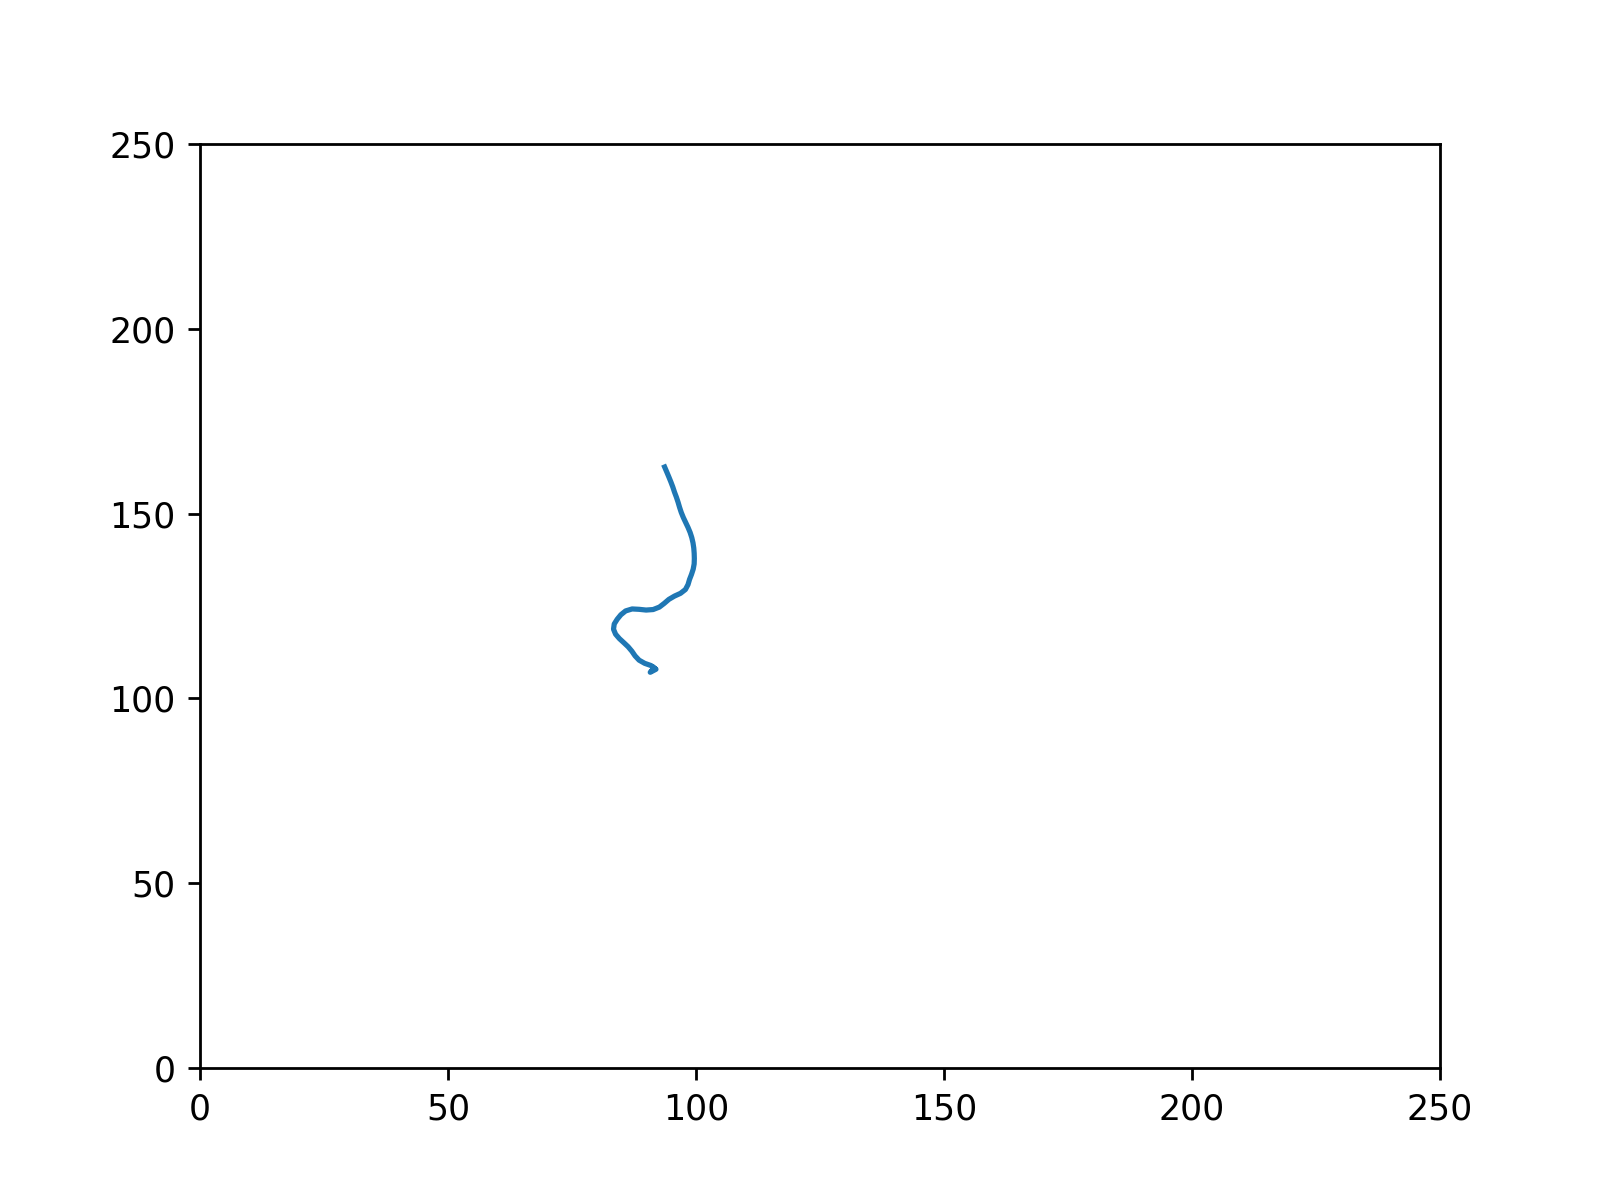

In [7]:
def display(points):
    plt.scatter(points)

    
point1 = Point(5, 250, 5, 250, fixed=True)

xs = np.arange(6, 56, 1)
ys = np.arange(249, 199, -1)

points = [Point(xs[i], ys[i], xs[i], ys[i]) for i in range(50)]    
    
points.insert(0, point1)

segments = [Segment(points[i], points[i+1]) for i in range(len(points)-1)]

dt = 1/1000

#############################################

debug = []

#Animation cell
fig, ax = plt.subplots()

ax.set_xlim(0, width)
ax.set_ylim(0, width)

def animate(i):    
    for ball in points:
        ball.update()    
    
    for segment in segments:
        segment.update()
    
    fix_constraints(points)
    
    #Update plot for animation
    lines.set_data(np.transpose([[p.x, p.y] for p in points]))
        
    return lines,

lines, = ax.plot(*np.transpose([[p.x, p.y] for p in points]))

#Create animation using the animate() function
myAnimation = animation.FuncAnimation(fig, animate, frames=20000,
                                      interval=1000*dt, blit=True)

fig.canvas.mpl_connect('motion_notify_event', onmove)
fig.canvas.mpl_connect('button_press_event', onclick)
fig.canvas.mpl_connect('button_release_event', offclick)

plt.show()